In [9]:
# Set up your matplotlib parameters so everything
# plots nicely

params = {"figure.figsize": (12,9),
          "font.size": 20,
          "font.weight": "normal",
          "xtick.major.size": 9,
          "xtick.minor.size": 4,
          "ytick.major.size": 9,
          "ytick.minor.size": 4,
          "xtick.major.width": 4,
          "xtick.minor.width": 3,
          "ytick.major.width": 4,
          "ytick.minor.width": 3,
          "xtick.major.pad": 8,
          "xtick.minor.pad": 8,
          "ytick.major.pad": 8,
          "ytick.minor.pad": 8,
          "lines.linewidth": 3,
          "lines.markersize": 10,
          "axes.linewidth": 4,
          "legend.loc": "best",
          "text.usetex": False,    
          "xtick.labelsize" : 20,
          "ytick.labelsize" : 20,
          }

import matplotlib
matplotlib.rcParams.update(params)

In [10]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from astropy.time import Time

% matplotlib inline

Add a quick and easy setting for whether you'd like to save the figures or not.

In [11]:
save_figures = False

Set up a colour and a marker for each season to use for every plot.

In [12]:
season_colours = ['#4363d8', '#911eb4', '#f032e6', '#e6194b', '#f58231', '#ffe119']
season_colours *= 6

season_markers = ['o', 's', '^', 'd']
season_markers *= 6

Load the optical observations that have been split
into semesters using <em>Process_Optical_Data.py</em>
(or <em>Process_Optical_Data.ipynb</em>) and the
period information from <em>LombScargle_Analysis.py</em>
(or <em>LombScargle_Analysis.ipynb</em>).

In [13]:
all_optical_info = np.load('TYC_optical_semesters.npy')
optical_mjd_chunks = all_optical_info[0]
optical_mag_chunks = all_optical_info[1]
optical_mag_e_chunks = all_optical_info[2]
optical_name_chunks = all_optical_info[3]

mean_all_V = np.mean(optical_mag_chunks[-1])

periods = np.load('TYC_LS_periods.npy')
period_errors = np.load('TYC_LS_periodErrors.npy')

You'll need the times and dates of the Swift observations and the SALT and LCO observations.

In [14]:
SALT_values = np.load('SALT_radial_velocities.npy')
LCO_values = np.load('LCO_radial_velocities.npy')

SALT_rv_jds = SALT_values[:, 0]
SALT_rv_times = Time(SALT_rv_jds, format='jd')
SALT_rv_mjds = SALT_rv_times.mjd

SALT_rvs = SALT_values[:, 1]
SALT_rv_errs = SALT_values[:, 2]

LCO_rv_jds = LCO_values[:, 0]
LCO_rv_times = Time(LCO_rv_jds, format='jd')
LCO_rv_mjds = LCO_rv_times.mjd

LCO_rvs = LCO_values[:, 1]
LCO_rv_errs = LCO_values[:, 2]

In [15]:
swift_isotime = np.array(['2019-04-18T20:45:17', '2019-04-18T22:18:47',
                          '2019-05-05T03:30:48', '2019-05-05T05:11:06',
                          '2019-05-05T09:41:44'])
swift_ap_time = Time(swift_isotime, scale='utc')
swift_mjds = swift_ap_time.mjd

### The MeerKAT observations

We need to the scale the MeerKAT flux densities as the source is near the FWHM of the MeerKAT primary beam. This is also where we mark the measurements that are non-detections.

In [16]:
meerkat_values = np.load('TYC_MeerKAT_fluxes.npy')
# The times in MJD
thunderkat_times = Time(meerkat_values[:, 0], format='mjd', scale='utc')
thunderkat_mjds = thunderkat_times.mjd
# the peak flux in Jy
thunderkat_flux = meerkat_values[:, 1]
# the uncertainty on the peak flux in Jy
thunderkat_flux_err = meerkat_values[:, 2]
# The RMS noise local to the source
tkt_local_rms = np.load('TYC_MeerKAT_local_RMS.npy')

# The scale value calculated in the paper
# as the source is at the FWHM of the
# primary beam of MeerKAT
tkt_scale = 2.0017550340402122
tkt_scale_err = 0.20242296072260868

In [17]:
# For some points the flux is an extreme outlier.
# This is because of the noise in the image and
# is a artefact. Set the value of any of these points
# to the detection threshold.
outlier = np.where(thunderkat_flux_err>6e-4)[0]
thunderkat_flux_err[outlier] = tkt_local_rms[outlier]
thunderkat_flux[outlier] = 2.*tkt_local_rms[outlier]

# Treat non-detections (below 2 times the local RMS)
# in the same way as outliers
below_noise = np.where((thunderkat_flux/(2*tkt_local_rms))<1)[0]
thunderkat_flux[below_noise] = 2*tkt_local_rms[below_noise]
thunderkat_flux_err[below_noise] = tkt_local_rms[below_noise]

# Plot the outliers and non-detections
# as upper limits
thunderkat_upperlims = np.zeros(len(thunderkat_flux))
thunderkat_upperlims[below_noise] = 1
thunderkat_upperlims[outlier] = 1
# Turn this into a boolean array for
# plotting
uls = thunderkat_upperlims.astype(bool)

# Scale the flux density of the source as it
# is close to the FWHM of the primary beam
# of MeerKAT
tkt_scaled_flux = thunderkat_flux*tkt_scale
tkt_scaled_err = np.abs(tkt_scaled_flux*
                        np.sqrt((thunderkat_flux_err/
                                 thunderkat_flux)**2+
                                (tkt_scale_err/tkt_scale)**2))
scaled_values = np.hstack((np.expand_dims(thunderkat_mjds, axis=1),
                           np.expand_dims(tkt_scaled_flux, axis=1),
                           np.expand_dims(tkt_scaled_err, axis=1)))
np.save('TYC_MeerKAT_ScaledFlux', scaled_values)

## Make the radio light curve plot

This is Figure 2. in the paper.

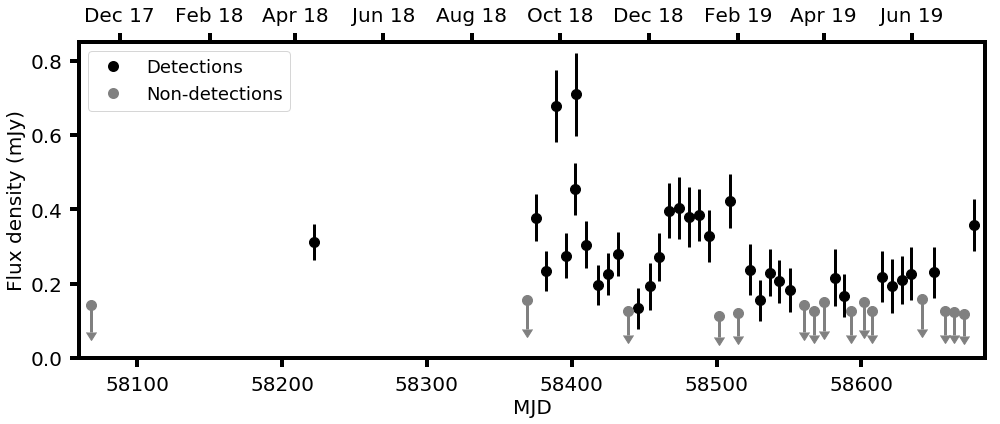

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Plot the detections as black points
ax.errorbar(thunderkat_mjds[~uls], (tkt_scaled_flux[~uls])*1e3,
            yerr=(np.abs(tkt_scaled_err[~uls]))*1e3, 
            fmt='o', uplims=thunderkat_upperlims[~uls],
            c='Black', label='Detections')
# Plot the upper limits as grey points
ax.errorbar(thunderkat_mjds[uls], (tkt_scaled_flux[uls])*1e3,
            yerr=(np.abs(tkt_scaled_err[uls]))*1e3, 
            fmt='o', uplims=thunderkat_upperlims[uls],
            c='Grey', label='Non-detections')

ax.set_ylabel('Flux density (mJy)', fontsize=20)
ax.set_xlabel('MJD', fontsize=20)

# Make a copy of the axes so that you can
# plot the dates along the top (as well
# as the MJDs along the bottom)
ax2 = ax.twiny()
ax2.xaxis.tick_top()
ax2.set_xticks([58088, 58150, 58209,
                58270, 58331, 58392,
                58453, 58515, 58574,
                58635, 58696, 58757])
ax2.set_xticklabels(['Dec 17','Feb 18','Apr 18',
                     'Jun 18','Aug 18', 'Oct 18',
                     'Dec 18', 'Feb 19', 'Apr 19',
                     'Jun 19', 'Aug 19', 'Oct 19'])

ax.set_ylim(0, 0.85)
ax2.set_ylim(0, 0.85)
ax.set_xlim(58060, 58685)
ax2.set_xlim(58060, 58685)

# Make a nice legend
detection_dot = mlines.Line2D([], [], color='Black', marker='o',
                         markeredgecolor='Black', linestyle='None',
                         markersize=8, markeredgewidth=3,
                         label='Detections')
nondetection_dot = mlines.Line2D([], [], color='Grey', marker='o',
                         markeredgecolor='Grey', linestyle='None',
                         markersize=8, markeredgewidth=3,
                         label='Non-detections')
leg1 = ax.legend(handles=[detection_dot, nondetection_dot],
                 fontsize=18, frameon=True, loc='upper left')

plt.tight_layout()

if save_figures:
    plt.savefig('Radio_LightCurve.eps',
                transparent=False)

### Now make the radio and optical light curve

This is Figure 10. in the paper.

21.25466261709822 ASAS-SN g


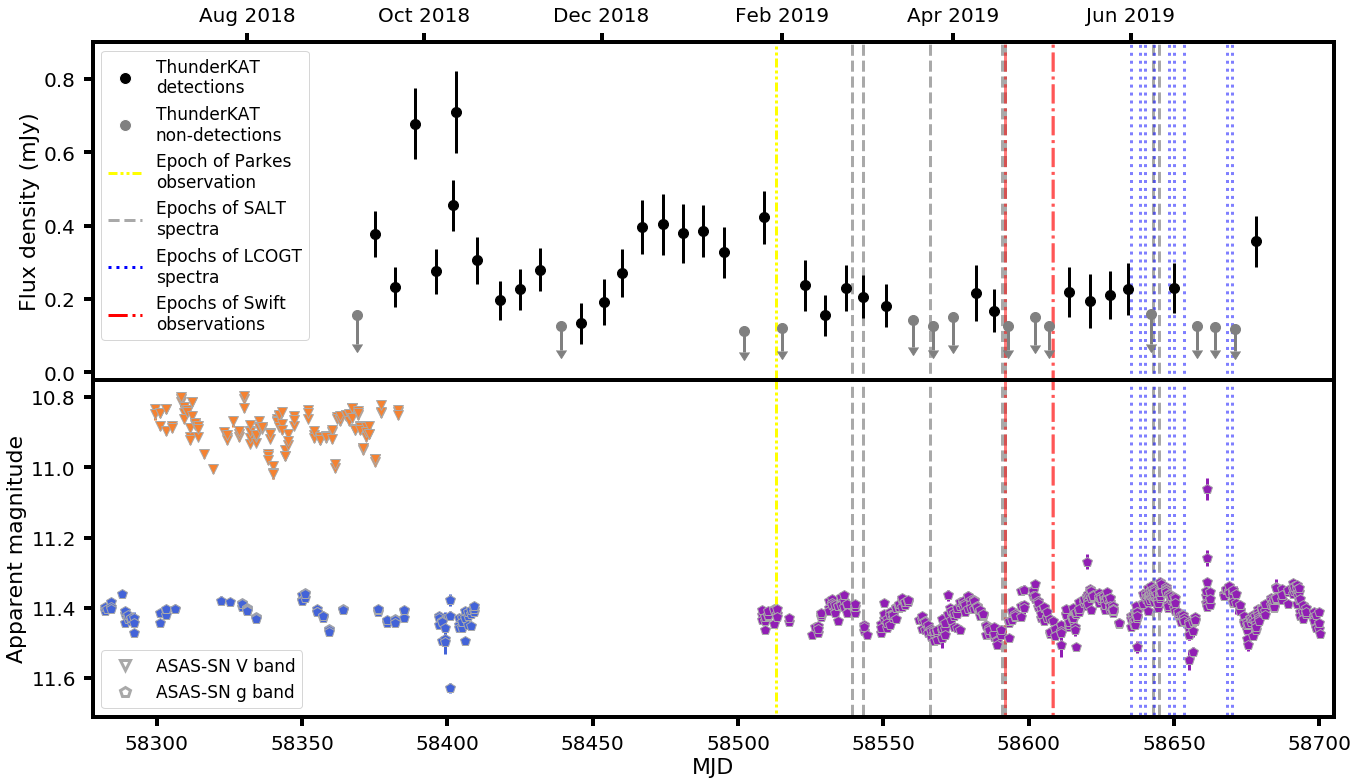

In [19]:
pointcol = 'Black'
framecol = 'Black'
fontsize = 22
pointsize = 10

fig, ax = plt.subplots(2, 1, figsize=(19, 11))
j = -2
p = periods[-1]
print(p, optical_name_chunks[j])
zero = optical_mjd_chunks[-2][0]
mjd = optical_mjd_chunks[j]
mag = optical_mag_chunks[j]

ax[0].errorbar(thunderkat_mjds[~uls], (tkt_scaled_flux[~uls])*1e3,
            yerr=(np.abs(tkt_scaled_err[~uls]))*1e3, 
            fmt='o', uplims=thunderkat_upperlims[~uls],
            c='Black', label='Detections')
ax[0].errorbar(thunderkat_mjds[uls], (tkt_scaled_flux[uls])*1e3,
            yerr=(np.abs(tkt_scaled_err[uls]))*1e3, 
            fmt='o', uplims=thunderkat_upperlims[uls],
            c='Grey', label='Non-detections')
j = 16
ax[1].errorbar(optical_mjd_chunks[j], optical_mag_chunks[j],
               yerr=optical_mag_e_chunks[j],
               fmt='v', c=season_colours[j],
               markeredgecolor='DarkGrey')
j = 18
ax[1].errorbar(optical_mjd_chunks[j], optical_mag_chunks[j],
               yerr=optical_mag_e_chunks[j],
               fmt='p', c=season_colours[j],
               markeredgecolor='DarkGrey')
j = 19
ax[1].errorbar(optical_mjd_chunks[j], optical_mag_chunks[j],
               yerr=optical_mag_e_chunks[j],
               fmt='p', c=season_colours[j],
               markeredgecolor='DarkGrey')


for mjd in SALT_rv_mjds:
    SALT_leg = ax[0].plot(np.ones(10)*mjd, np.linspace(-1, 1, 10), '--',
               c='DarkGrey', zorder=0)
    ax[1].plot(np.ones(10)*mjd, np.linspace(10, 12, 10), '--',
               c='DarkGrey', zorder=0)
for mjd in LCO_rv_mjds:
    LCO_leg = ax[0].plot(np.ones(10)*mjd, np.linspace(-1, 1, 10), ':',
               c='Blue', zorder=0, alpha=0.5, label='Epochs of LCO spectra')
    ax[1].plot(np.ones(10)*mjd, np.linspace(10, 12, 10), ':',
               c='Blue', zorder=0, alpha=0.5)

for mjd in swift_mjds:
    swift_leg = ax[0].plot(np.ones(10)*mjd, np.linspace(-1, 1, 10), '-.',
               c='Red', zorder=0, alpha=0.3, label='Epochs of Swift observations')
    ax[1].plot(np.ones(10)*mjd, np.linspace(10, 12, 10), '-.',
               c='Red', zorder=0, alpha=0.3)

parkes_date = Time('2019-01-30T00:00:00.0')
ax[0].plot(np.ones(10)*parkes_date.mjd, np.linspace(-1, 1, 10),
           linestyle=(0, (3, 1, 1, 1, 1, 1)), c='Yellow', zorder=0)
ax[1].plot(np.ones(10)*parkes_date.mjd, np.linspace(10, 12, 10),
           linestyle=(0, (3, 1, 1, 1, 1, 1)), c='Yellow', zorder=0)

parkes_line = mlines.Line2D([], [], color='Yellow', linestyle=(0, (3, 1, 1, 1, 1, 1)),
                          label='Epoch of Parkes\nobservation')
salt_line = mlines.Line2D([], [], color='DarkGrey', linestyle='--',
                          label='Epochs of SALT\nspectra')
lco_line = mlines.Line2D([], [], color='Blue', linestyle=':',
                          label='Epochs of LCOGT\nspectra')
swift_line = mlines.Line2D([], [], color='Red', linestyle='-.',
                          label='Epochs of Swift\nobservations')
TKT_dot = mlines.Line2D([], [], markerfacecolor='Black', marker='o',
                         markersize=pointsize+2,
                         label='ThunderKAT\ndetections', color='w')

TKT_non_dot = mlines.Line2D([], [], markerfacecolor='Grey', marker='o',
                         markersize=pointsize+2,
                         label='ThunderKAT\nnon-detections', color='w')
leg0 = ax[0].legend(handles=[TKT_dot, TKT_non_dot, parkes_line, salt_line, lco_line, swift_line],
                    fontsize=17, frameon=True, loc='upper left')

asassnV_dot = mlines.Line2D([], [], color='None', marker='v',
                         markeredgecolor='DarkGrey',
                         markersize=pointsize, markeredgewidth=3,
                         label='ASAS-SN V band')
asassng_dot = mlines.Line2D([], [], color='None', marker='p',
                         markeredgecolor='DarkGrey',
                         markersize=pointsize, markeredgewidth=3,
                         label='ASAS-SN g band')
leg1 = ax[1].legend(handles=[asassnV_dot, asassng_dot],
                 fontsize=17, frameon=True, loc='lower left')

ax[1].set_xlabel('MJD', fontsize=fontsize, color=framecol)
ax[0].set_ylabel('Flux density (mJy)', fontsize=fontsize, color=framecol)
ax[1].set_ylabel('Apparent magnitude', fontsize=fontsize, color=framecol)

for i in range(2):
    ax[i].set_xlim(58278, 58705)
    ax[i].tick_params(axis='both', colors=framecol)
    ax[i].spines['bottom'].set_color(framecol)
    ax[i].spines['top'].set_color(framecol)
    ax[i].spines['left'].set_color(framecol)
    ax[i].spines['right'].set_color(framecol)

ax[0].set_ylim(-0.02, 0.9)
ax[1].set_ylim(10.75, 11.71)

ax[0].xaxis.tick_top()
ax[0].set_xticks([58331, 58392, 58453,
                  58515, 58574, 58635])
ax[0].set_xticklabels(['Aug 2018', 'Oct 2018',
                       'Dec 2018', 'Feb 2019',
                       'Apr 2019', 'Jun 2019'])

ax[1].invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(hspace=0)

if save_figures:
    plt.savefig('Optical_Radio_LightCurve.eps', transparent=False)